## Python Modules

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series

In [8]:
directorio_actual = os.getcwd()
data_ts           = os.path.join(directorio_actual, 'data', 'processed', 'data_over_time_ds.pickle')

with open(data_ts, 'rb') as f:
    data_over_time_ds = pickle.load(f)

In [9]:
data_over_time_ds[0].head()

,date,frequency
0,2021-10-31 04:24:22.860,0.005138
1,2021-12-05 03:57:27.500,0.015413
2,2022-01-08 07:49:55.000,0.005138
3,2022-02-11 11:42:22.500,0.015413
4,2022-03-17 15:34:50.000,0.005138


### Handle Missings

In [26]:
# Índices de los tópicos a analizar
topics = [2, 6, 7]
df_ts_resultado = []

for i, df_topic in enumerate(data_over_time_ds):
    if i not in topics:
        continue

    df_topic['date'] = pd.to_datetime(df_topic['date']).dt.floor('D')
    fecha_minima = df_topic['date'].min()
    fecha_maxima = df_topic['date'].max()
    
    todas_fechas = pd.date_range(start=fecha_minima, end=fecha_maxima, freq='D')
    df_todas_fechas = pd.DataFrame({'date': todas_fechas})
    
    df_resultado = pd.merge(df_todas_fechas, df_topic, on='date', how='left')
    df_resultado['frequency'] = df_resultado['frequency'].interpolate(method='linear')
    
    df_ts_resultado.append(df_resultado)

    fig = px.line(df_resultado, x='date', y='frequency', title=f'Topic {i} over time')
    fig.show()

    print(f"\n--- Topic {i} ---")
    print(df_resultado)


--- Topic 2 ---
          date  frequency
0   2021-10-31   0.126407
1   2021-11-01   0.126407
2   2021-11-02   0.126407
3   2021-11-03   0.126407
4   2021-11-04   0.126407
..         ...        ...
782 2023-12-22   0.229267
783 2023-12-23   0.229887
784 2023-12-24   0.230507
785 2023-12-25   0.231126
786 2023-12-26   0.231746

[787 rows x 2 columns]



--- Topic 6 ---
          date  frequency
0   2022-10-08   0.141421
1   2022-10-09   0.143501
2   2022-10-10   0.145581
3   2022-10-11   0.147661
4   2022-10-12   0.149740
..         ...        ...
440 2023-12-22   0.399307
441 2023-12-23   0.405547
442 2023-12-24   0.411786
443 2023-12-25   0.418025
444 2023-12-26   0.424264

[445 rows x 2 columns]



--- Topic 7 ---
          date  frequency
0   2021-10-31   0.054965
1   2021-11-01   0.054965
2   2021-11-02   0.054965
3   2021-11-03   0.054965
4   2021-11-04   0.054965
..         ...        ...
782 2023-12-22   0.116396
783 2023-12-23   0.114780
784 2023-12-24   0.113163
785 2023-12-25   0.111547
786 2023-12-26   0.109930

[787 rows x 2 columns]


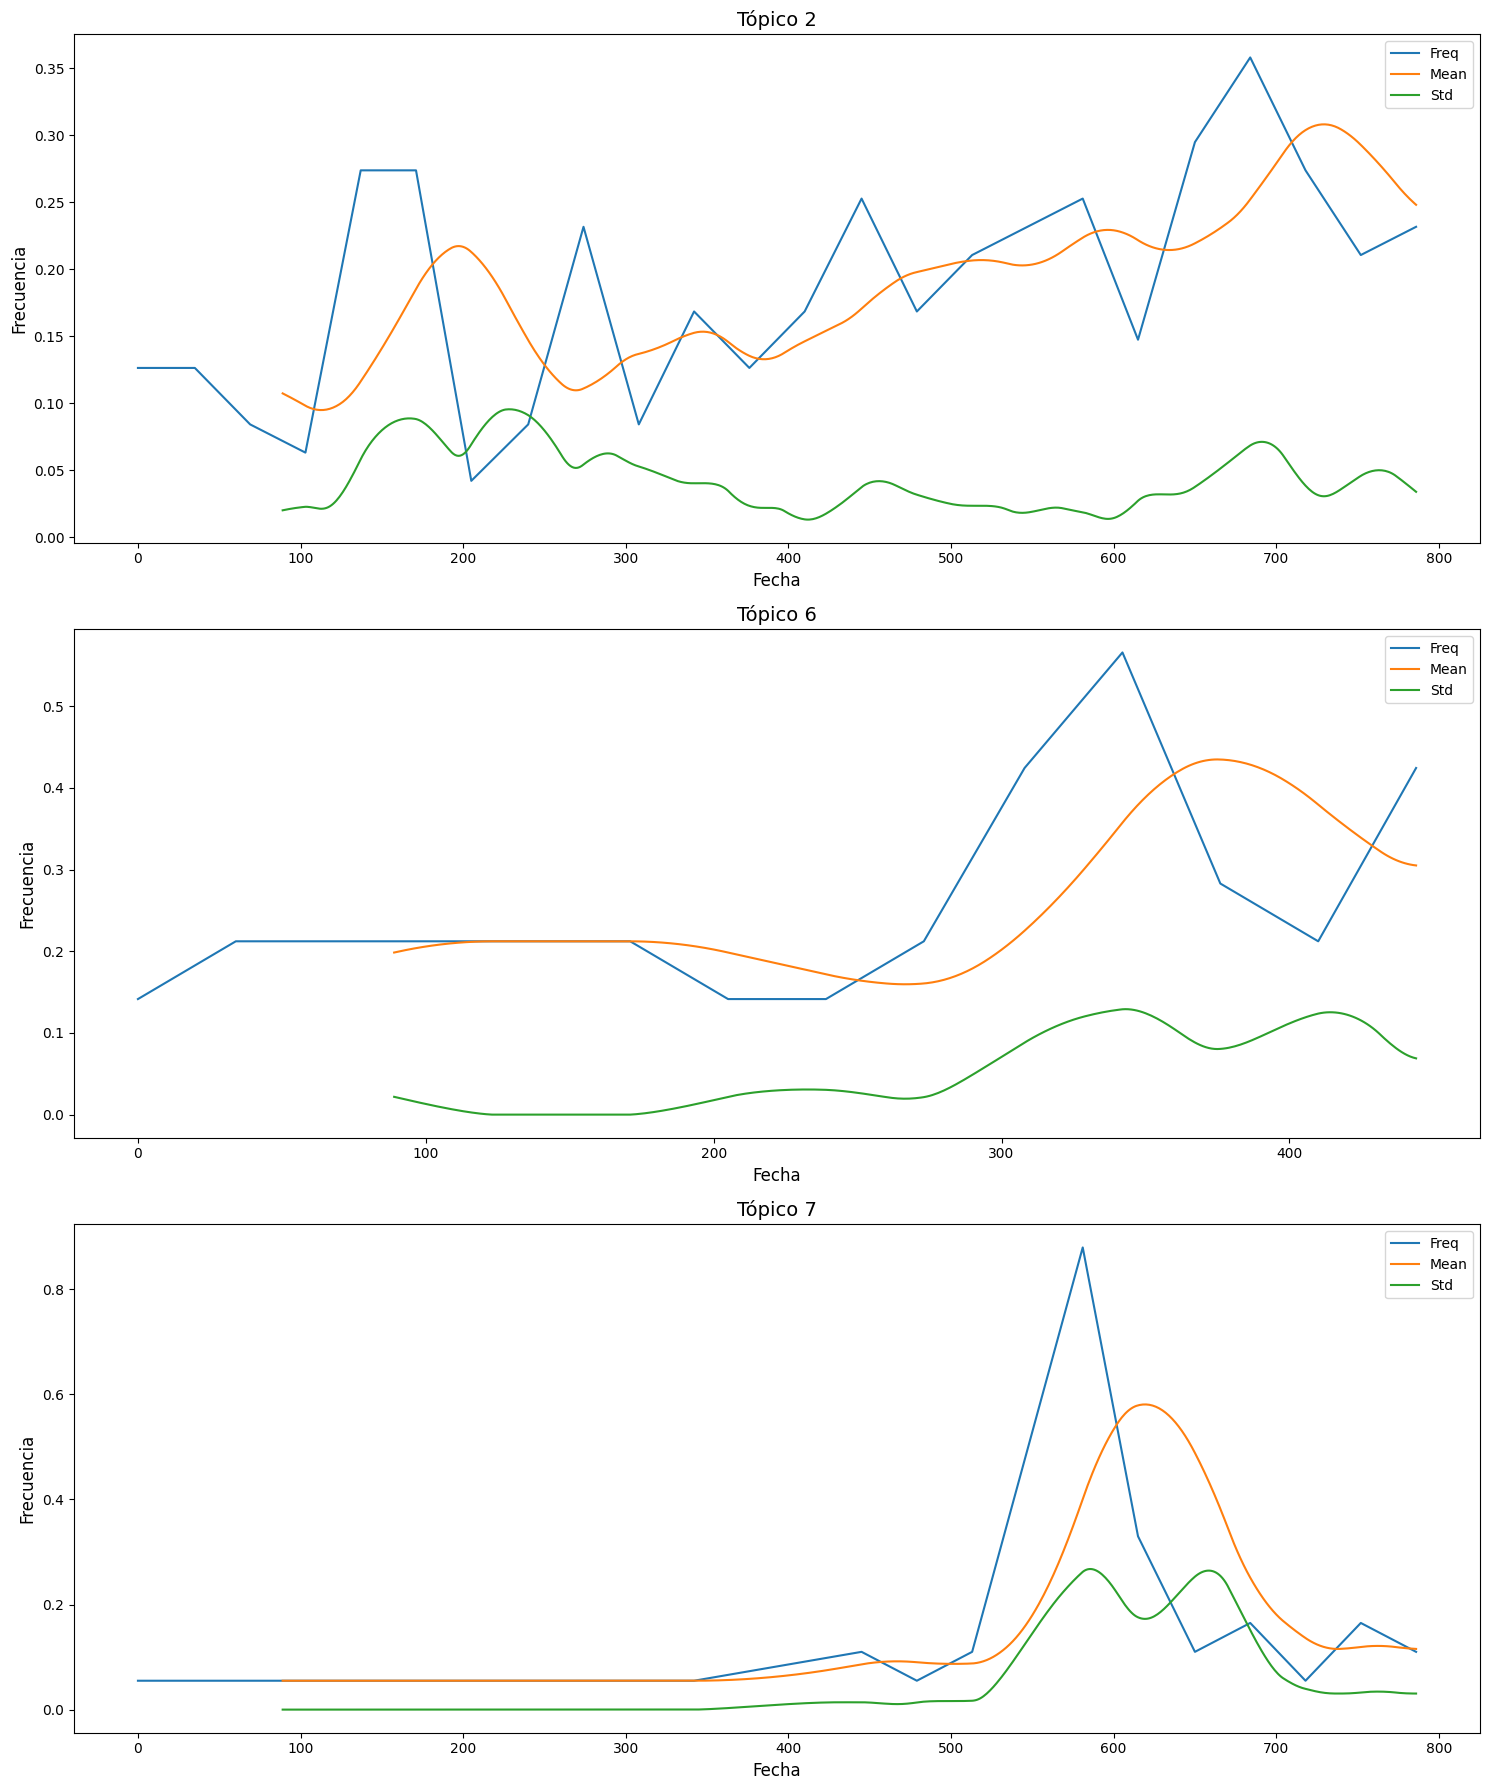

In [ ]:
# Índices de los tópicos a analizar
topics = [2, 6, 7] 

df_ts_filtrados = [df_ts_resultado[i] for i in topics]

num_topics = len(df_ts_filtrados)
rolling_window = 90

fig, axs = plt.subplots(nrows=num_topics, ncols=1, figsize=(15, 6 * num_topics))

if num_topics == 1:
    axs = [axs]

for i, (idx, df_resultado) in enumerate(zip(topics, df_ts_filtrados)):
    sns.lineplot(x=df_resultado.index, y=df_resultado['frequency'], ax=axs[i], label='Freq')
    sns.lineplot(x=df_resultado.index, y=df_resultado['frequency'].rolling(rolling_window).mean(), ax=axs[i], label='Mean')
    sns.lineplot(x=df_resultado.index, y=df_resultado['frequency'].rolling(rolling_window).std(), ax=axs[i], label='Std')
    axs[i].set_title(f'Tópico {idx}', fontsize=14)
    axs[i].set_ylabel('Frecuencia', fontsize=12)
    axs[i].set_xlabel('Fecha', fontsize=12)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [35]:
# Índices de los tópicos a analizar
topics_ = [2, 6, 7, 8] 

for i in topics_:
    df_resultado = df_ts_resultado[i]
    result = adfuller(df_resultado['frequency'])

    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'Tópico {i}:')
    print('ADF Statistic:', adf_stat)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpretación de estacionariedad
    if p_value < 0.05:
        print("✅ La serie es estacionaria")
    else:
        print("❌ La serie no es estacionaria")
    print('\n')

Tópico 2:
ADF Statistic: -4.048606428422919
p-value: 0.0011763240645968395
Critical Values:
   1%: -3.438707722728768
   5%: -2.8652288644673125
   10%: -2.568734303622865
✅ La serie es estacionaria


Tópico 6:
ADF Statistic: -2.51272627049764
p-value: 0.11240851153840559
Critical Values:
   1%: -3.4451978474132234
   5%: -2.8680864144212057
   10%: -2.5702569996789792
❌ La serie no es estacionaria


Tópico 7:
ADF Statistic: -3.4643613989327884
p-value: 0.00895095422478759
Critical Values:
   1%: -3.438707722728768
   5%: -2.8652288644673125
   10%: -2.568734303622865
✅ La serie es estacionaria


Tópico 8:
ADF Statistic: -2.852292402848634
p-value: 0.051183662743982776
Critical Values:
   1%: -3.4519023023726696
   5%: -2.8710320399170537
   10%: -2.57182745012602
❌ La serie no es estacionaria




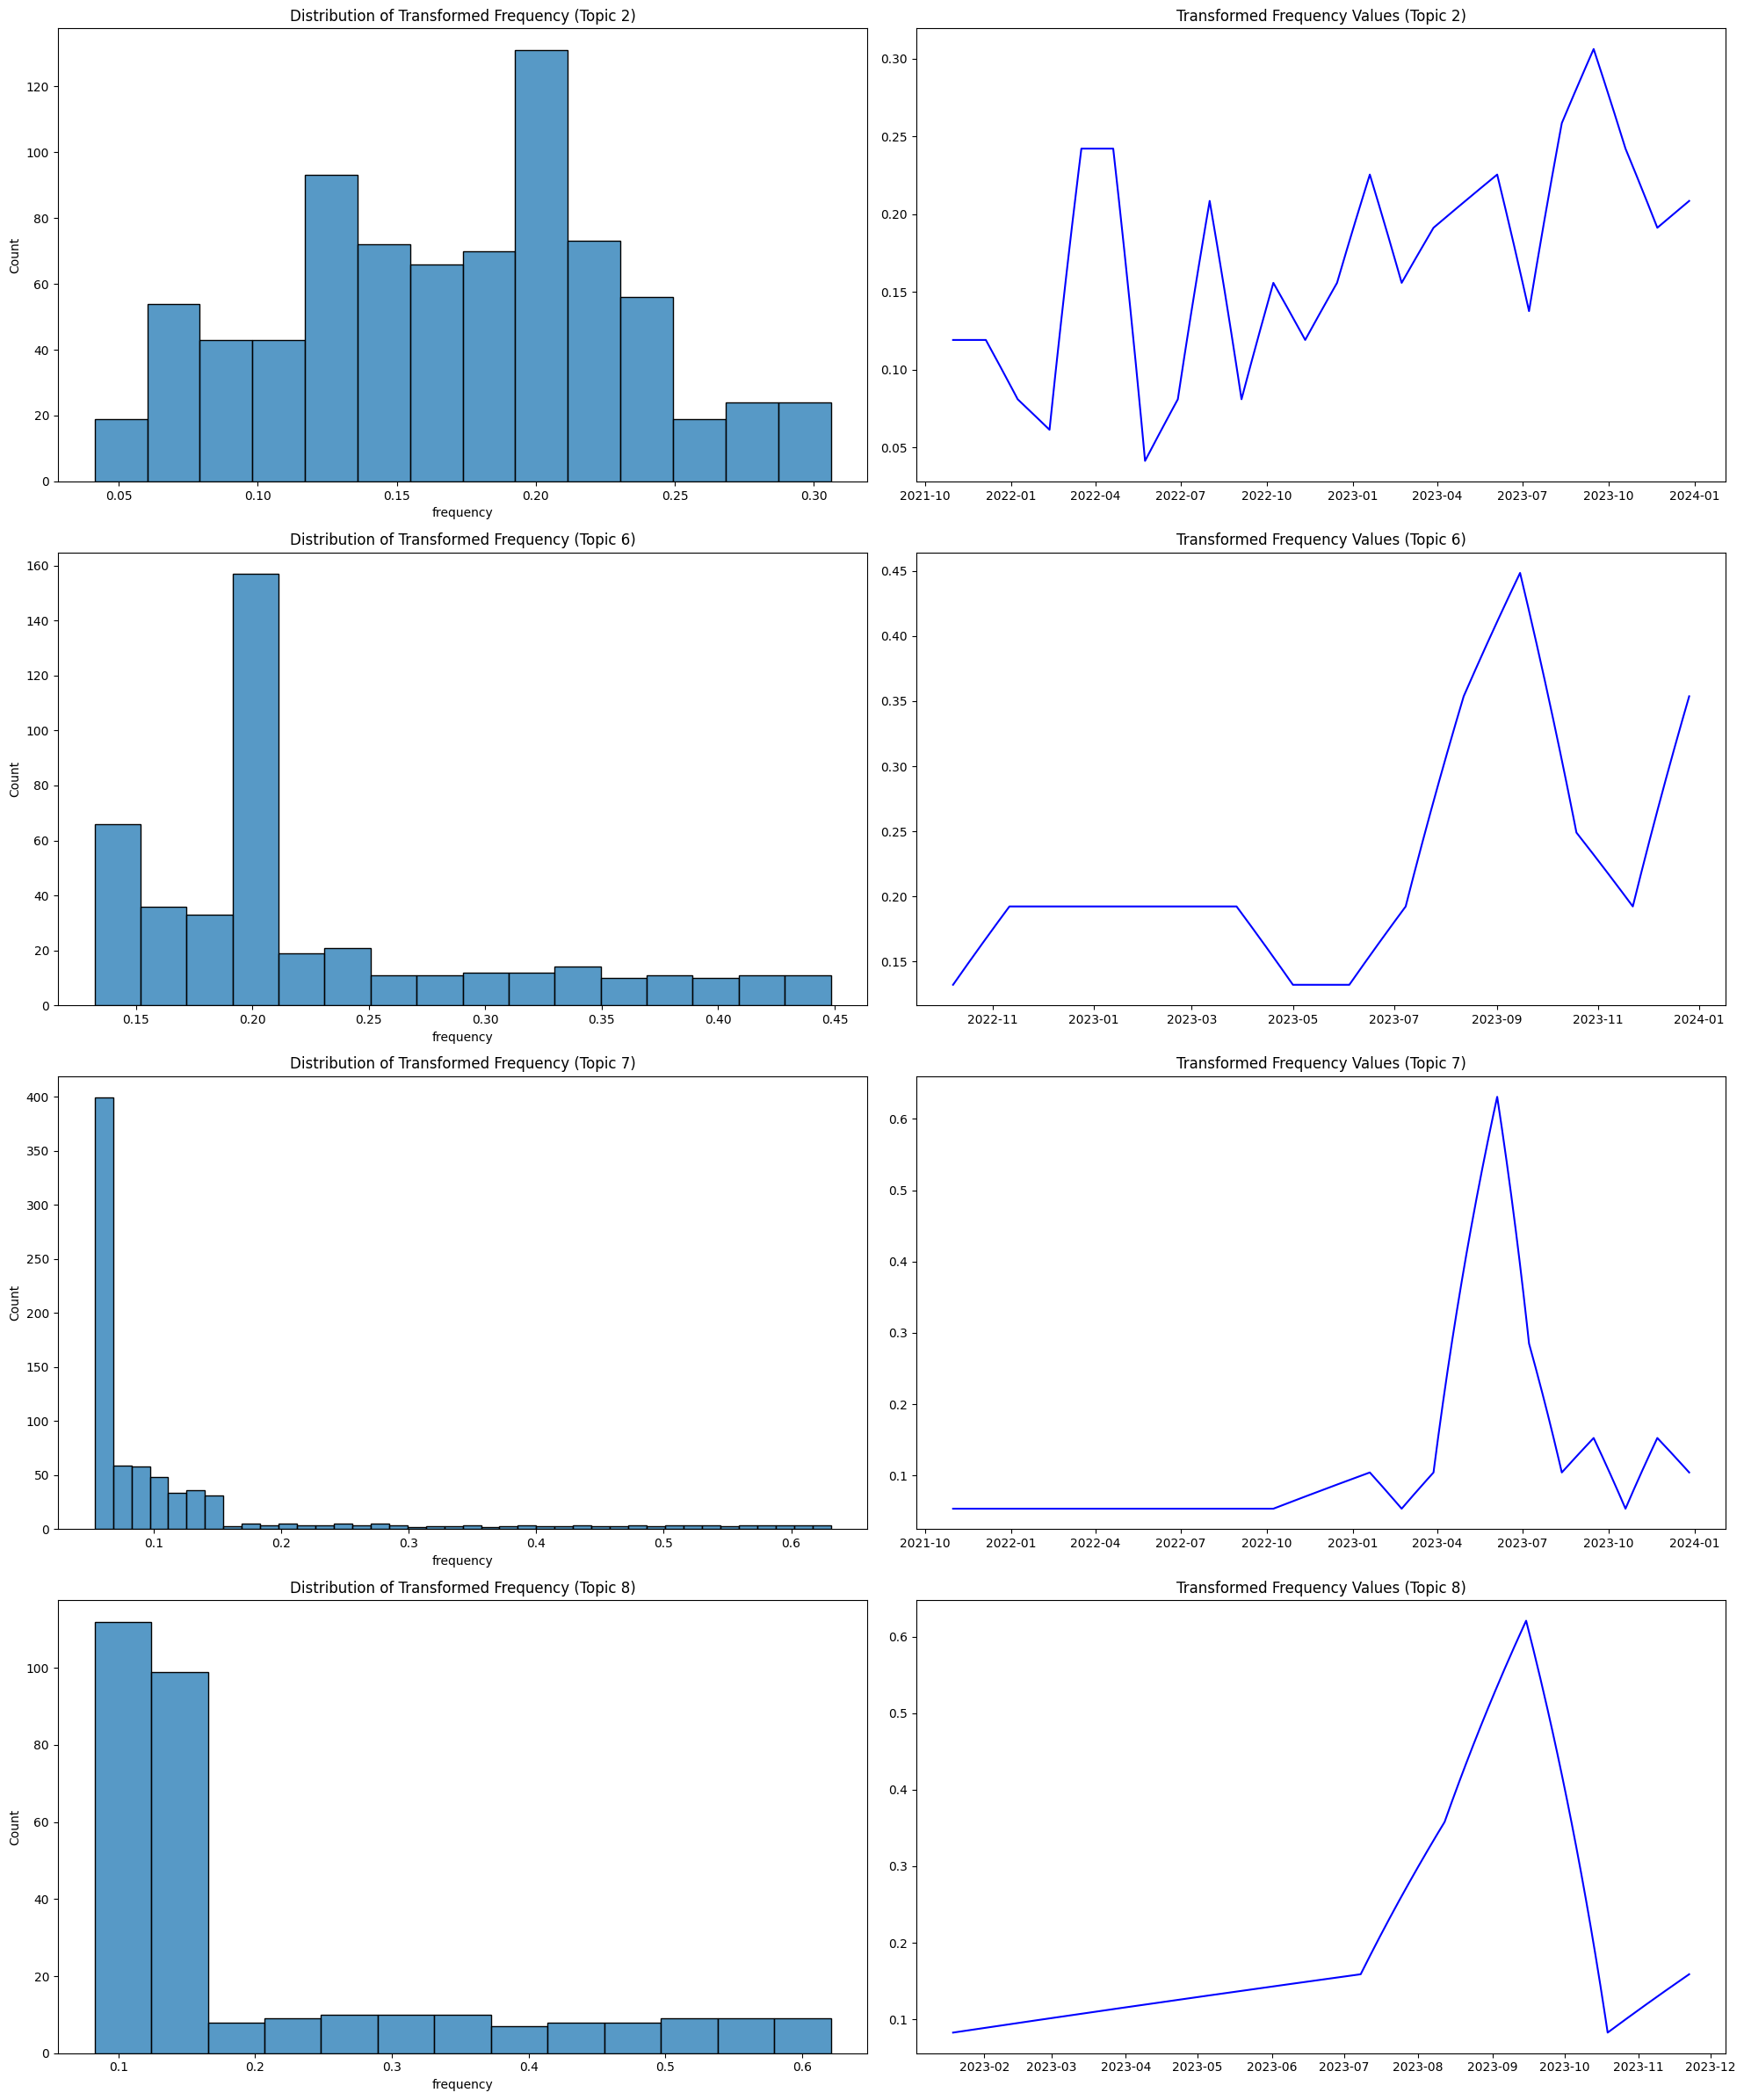

In [37]:
topics = [2, 6, 7, 8]

num_rows = len(topics)
f, ax = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 6 * num_rows))

# Si solo hay un tópico, ax no es lista, lo convertimos
if num_rows == 1:
    ax = [ax]

for idx_plot, idx_topic in enumerate(topics):
    df_resultado = df_ts_resultado[idx_topic]
    
    # Aplicar transformación logarítmica segura (en la misma serie)
    frequency_log = np.log1p(df_resultado['frequency'].clip(lower=0))

    # Histograma
    sns.histplot(frequency_log, ax=ax[idx_plot][0])
    ax[idx_plot][0].set_title(f'Distribution of Transformed Frequency (Topic {idx_topic})')

    # Línea temporal transformada
    ax[idx_plot][1].plot(df_resultado['date'], frequency_log, color='blue')
    ax[idx_plot][1].set_title(f'Transformed Frequency Values (Topic {idx_topic})')

plt.tight_layout()
plt.show()

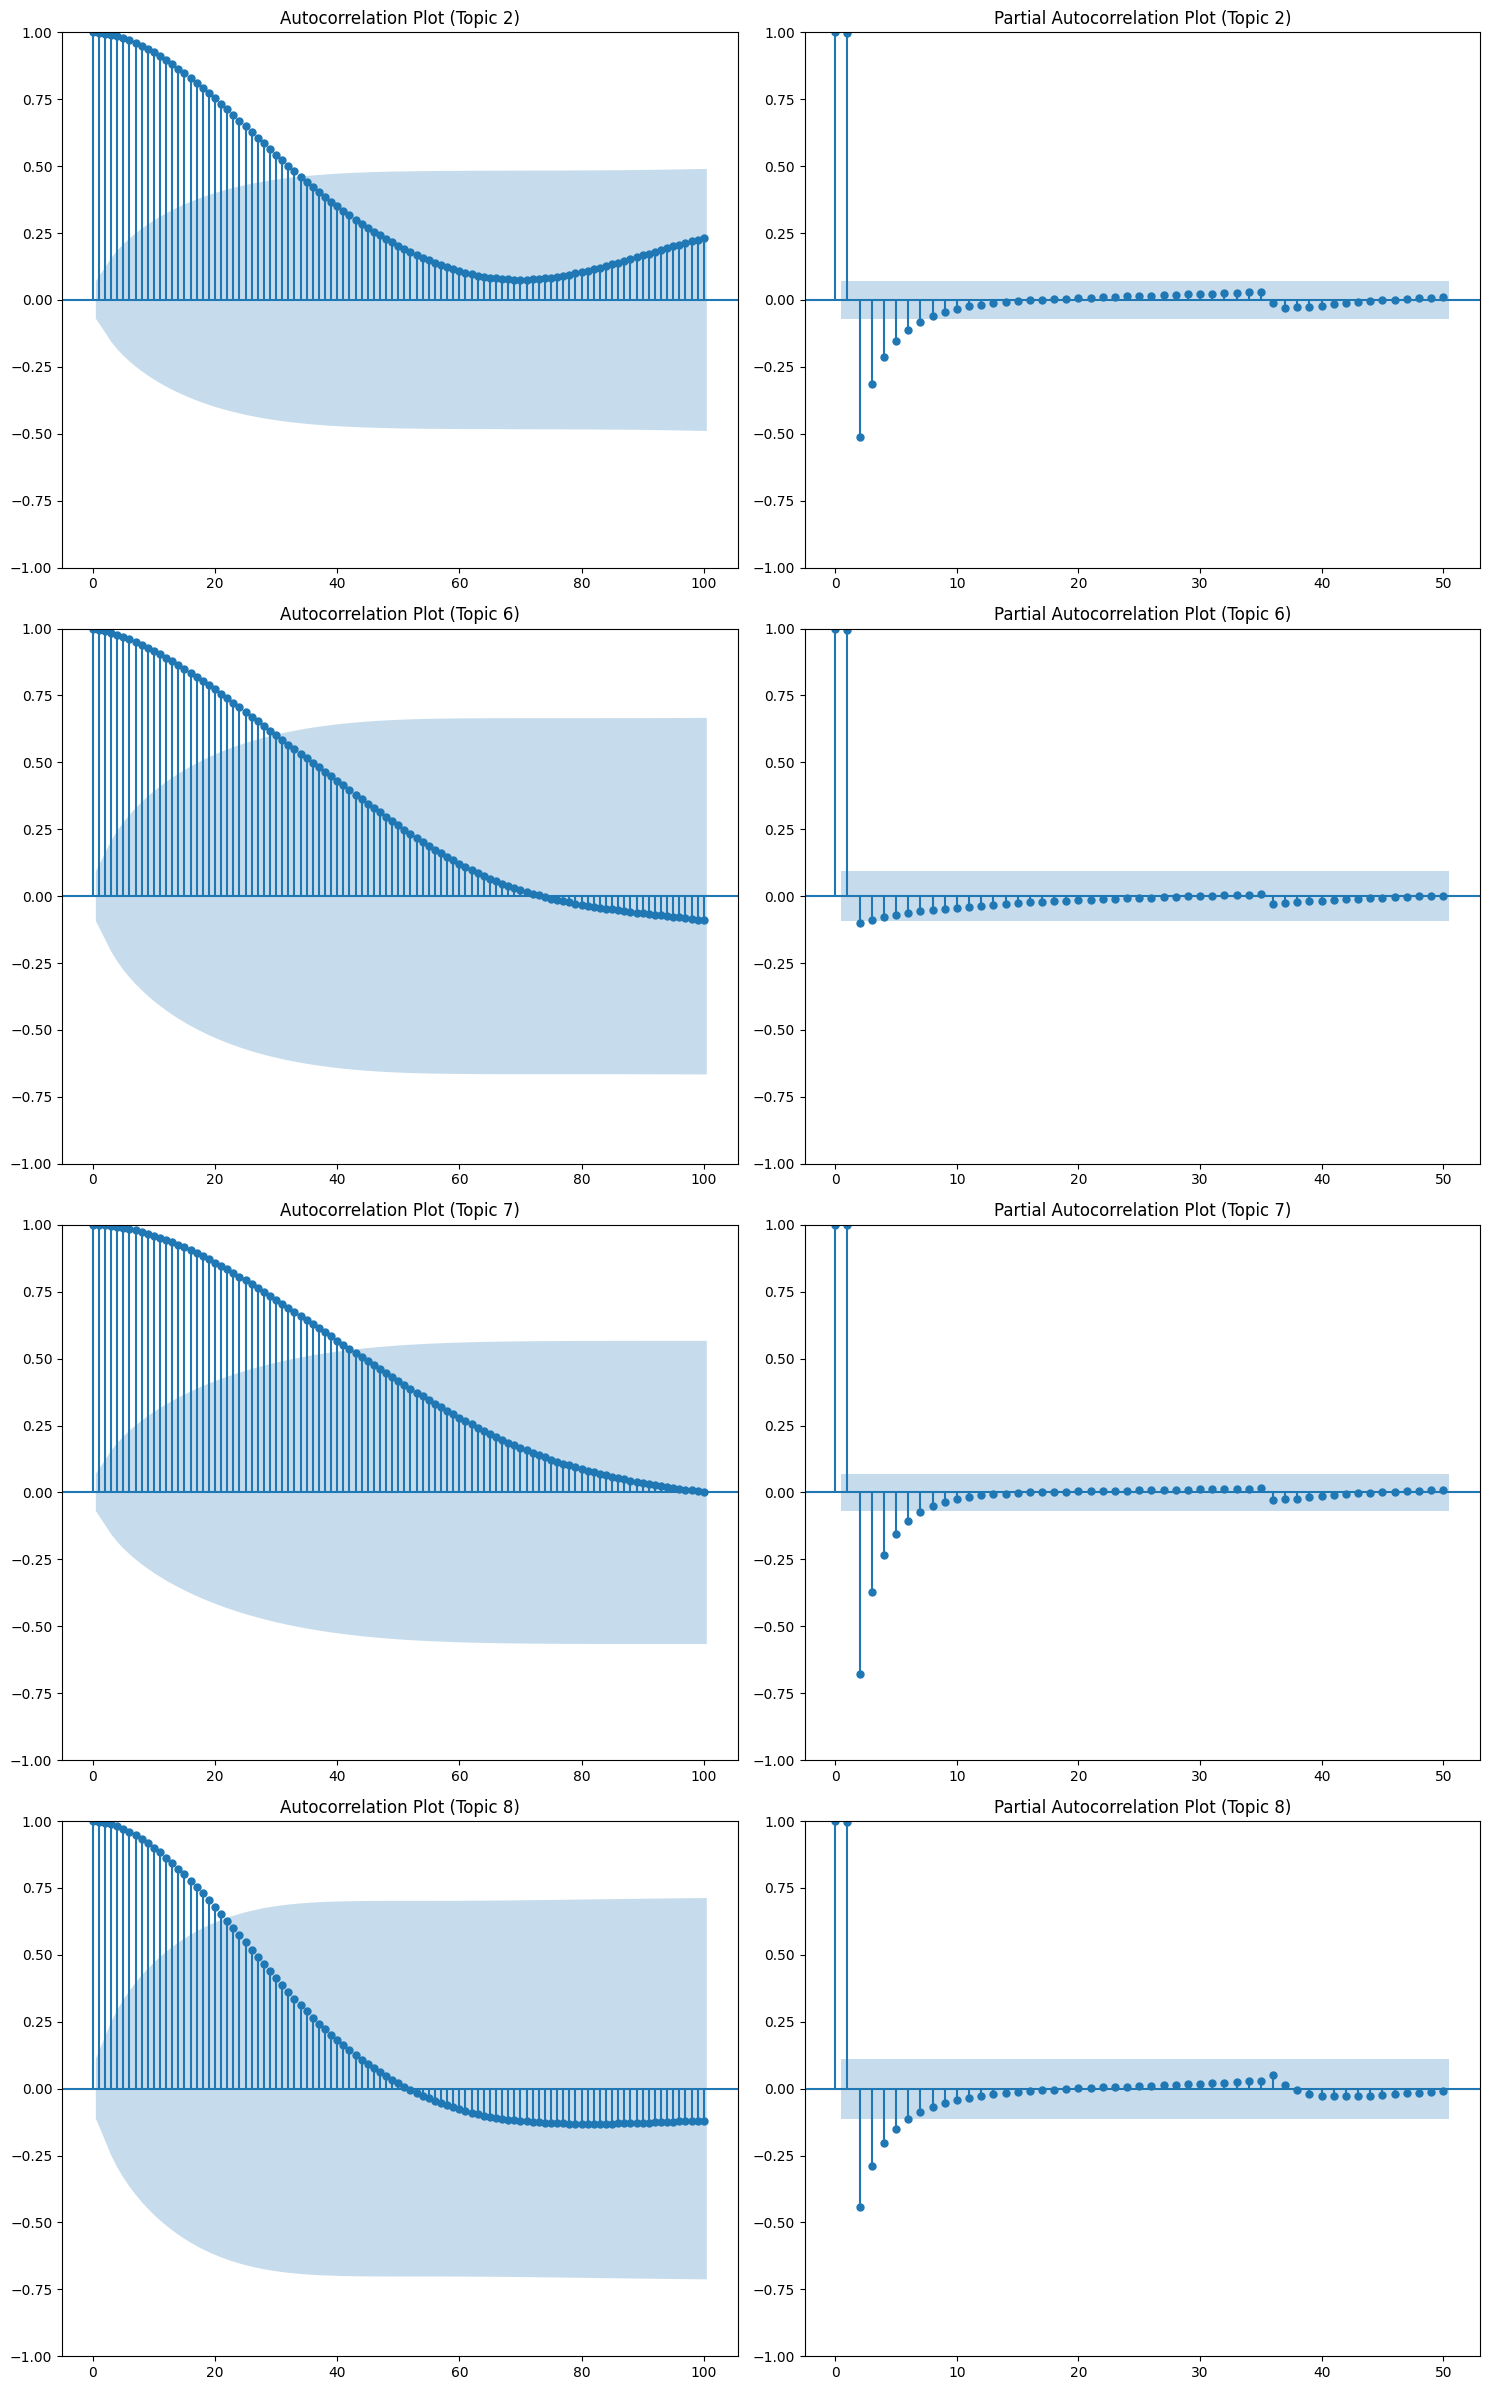

In [ ]:
# Índices de los tópicos a analizar
topics = [2, 6, 7, 8]  

num_rows = len(topics)
f, ax = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

if num_rows == 1:
    ax = [ax]

for idx_plot, idx_topic in enumerate(topics):
    df_resultado = df_ts_resultado[idx_topic]

    plot_acf(df_resultado['frequency'], lags=100, ax=ax[idx_plot][0])
    ax[idx_plot][0].set_title(f'Autocorrelation Plot (Topic {idx_topic})')

    plot_pacf(df_resultado['frequency'], lags=50, ax=ax[idx_plot][1])
    ax[idx_plot][1].set_title(f'Partial Autocorrelation Plot (Topic {idx_topic})')

plt.tight_layout()
plt.show()

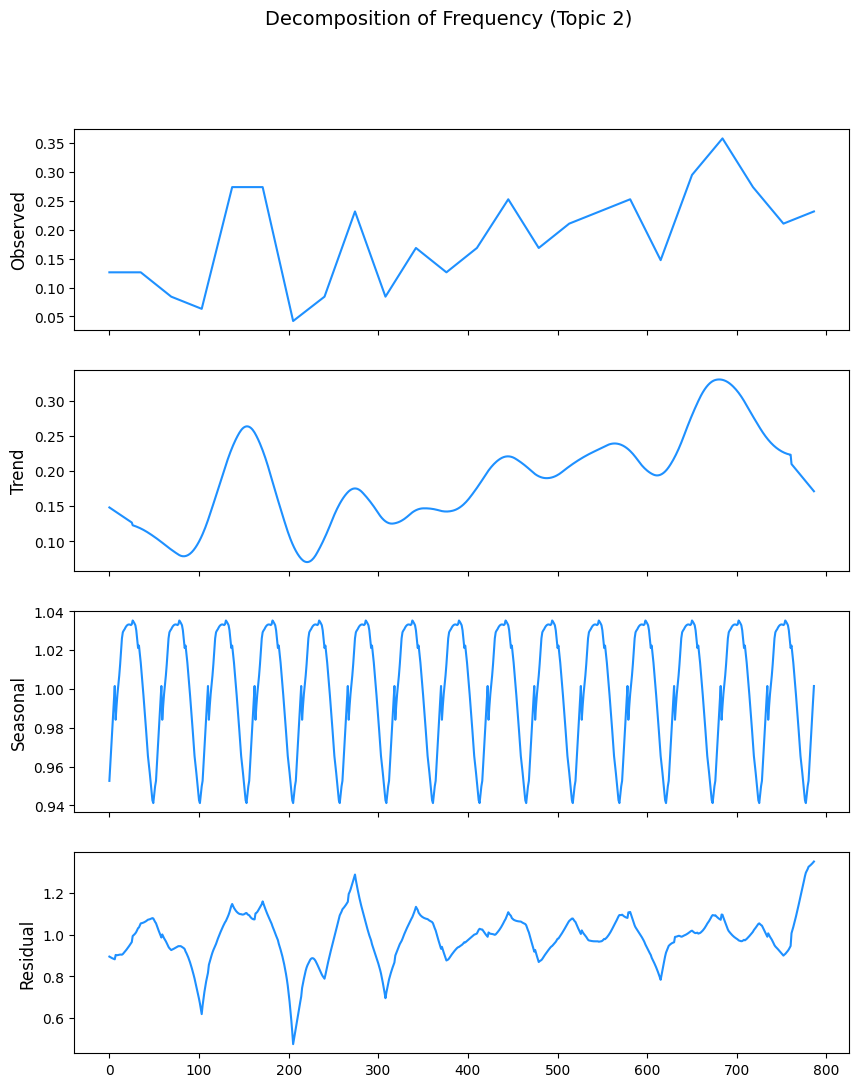

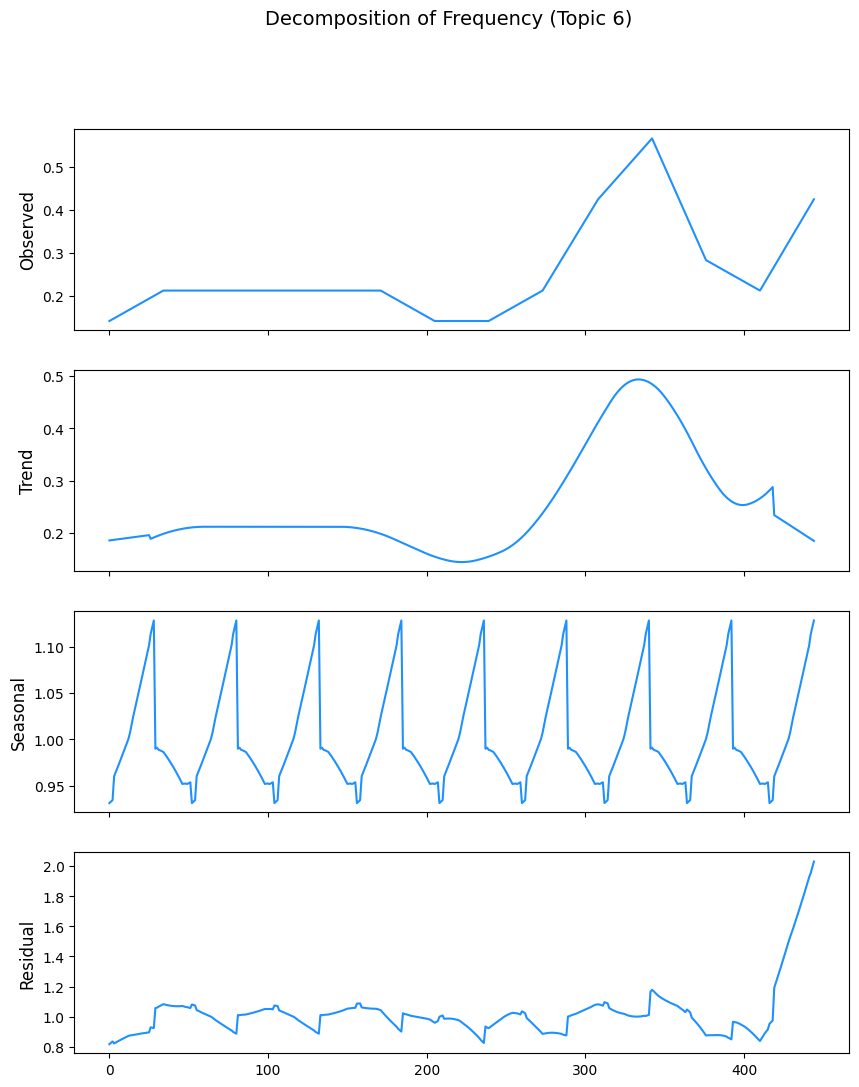

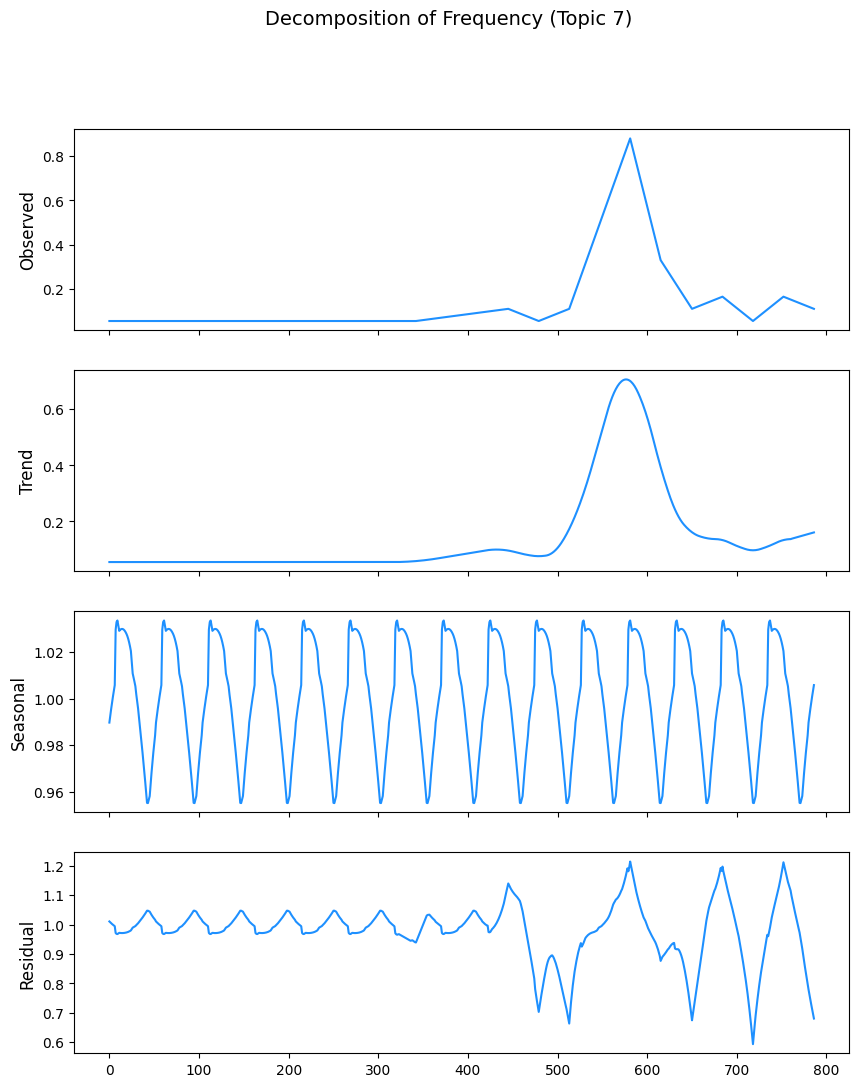

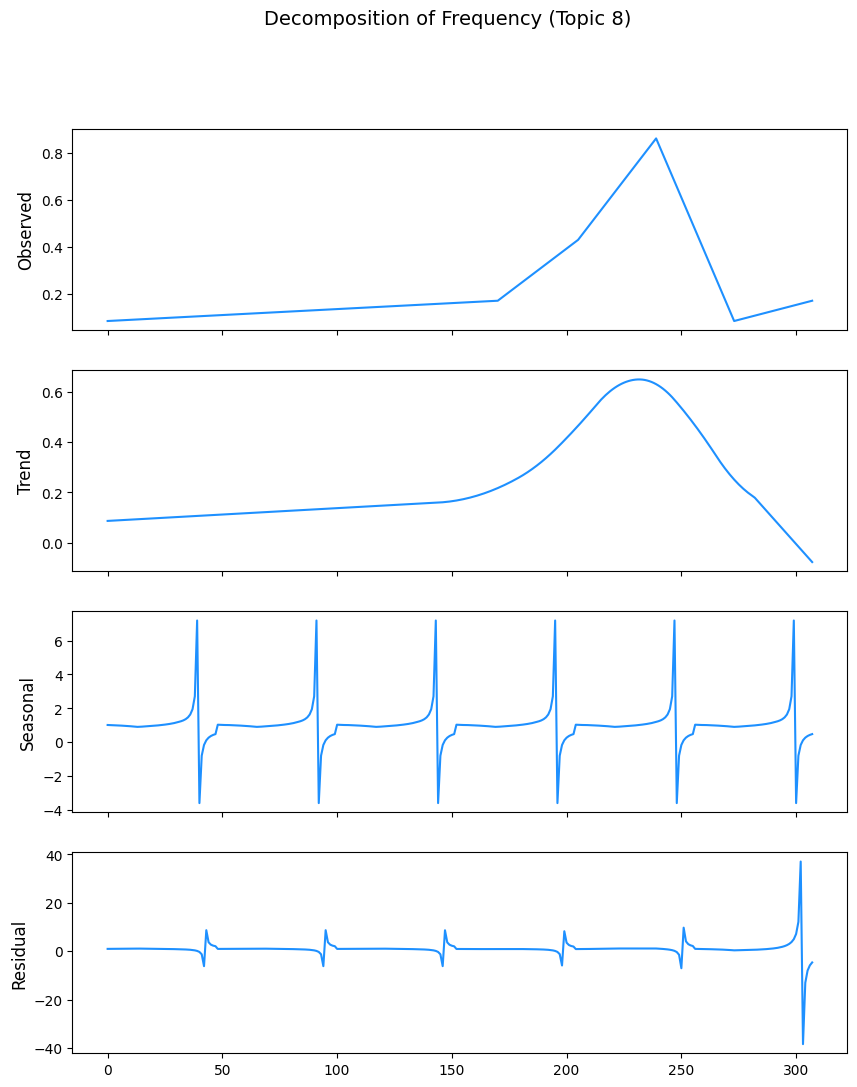

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Índices de los tópicos a analizar
topics = [2, 6, 7, 8]

period = 52
model = 'multiplicative'

for idx in topics:
    df_resultado = df_ts_resultado[idx]

    # Descomposición estacional
    res = seasonal_decompose(df_resultado['frequency'], period=period, model=model, extrapolate_trend='freq')

    # Graficar
    fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10, 12))
    titles = ['Observed', 'Trend', 'Seasonal', 'Residual']

    for j in range(4):
        ax[j].set_ylabel(titles[j], fontsize=12)

        if j == 0:
            df_resultado['frequency'].plot(ax=ax[j], legend=False, color='dodgerblue')
        elif j == 1:
            res.trend.plot(ax=ax[j], legend=False, color='dodgerblue')
        elif j == 2:
            res.seasonal.plot(ax=ax[j], legend=False, color='dodgerblue')
        elif j == 3:
            res.resid.plot(ax=ax[j], legend=False, color='dodgerblue')

    plt.suptitle(f'Decomposition of Frequency (Topic {idx})', fontsize=14)
    plt.show()


🔍 Análisis del Tópico 2


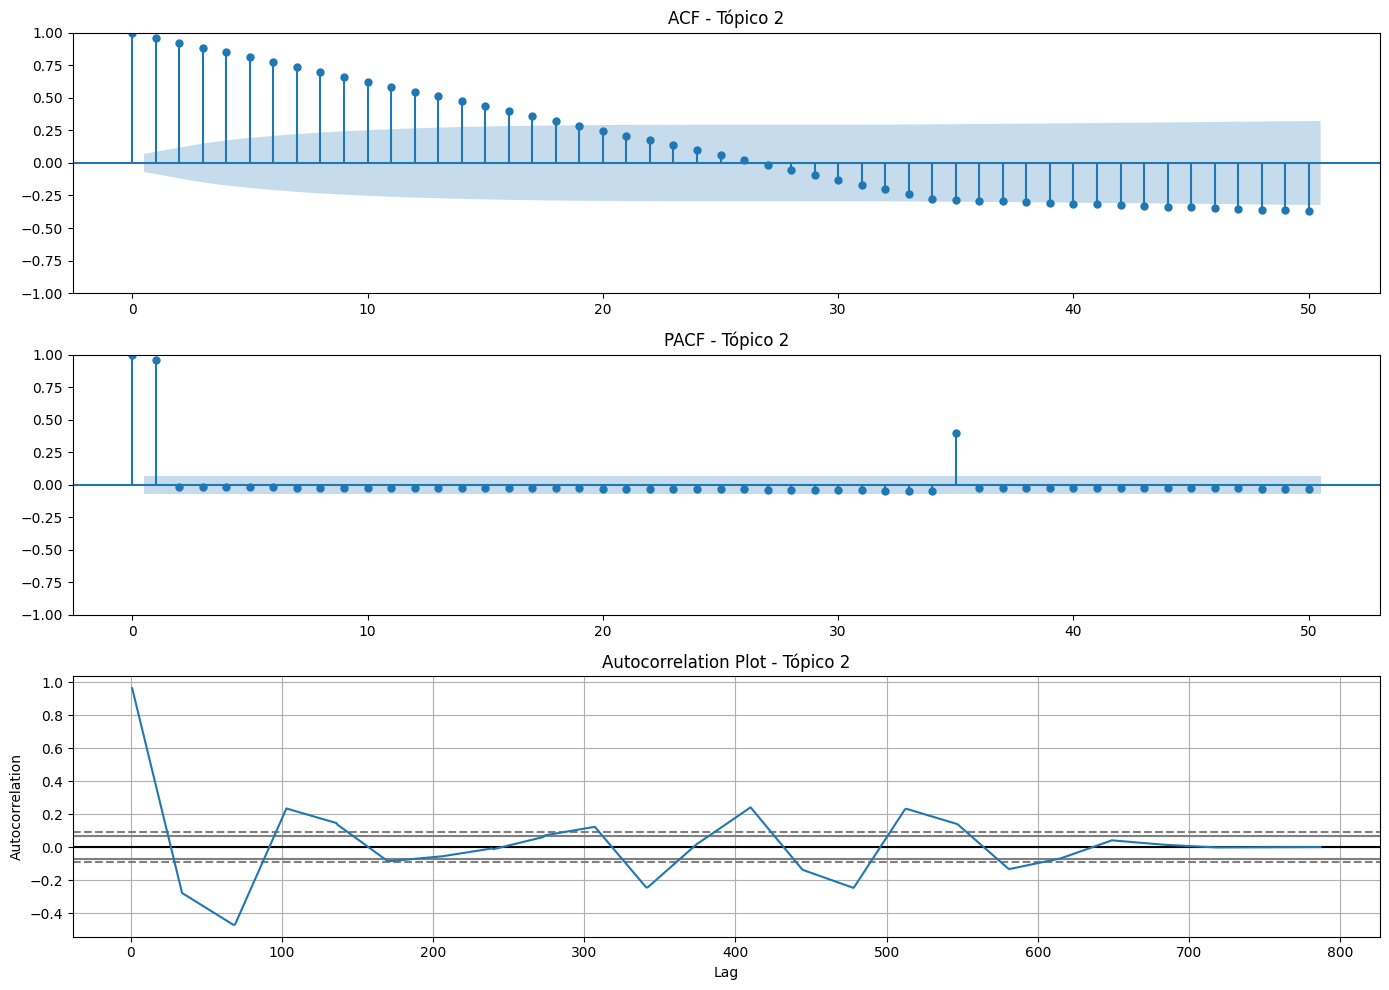


🔍 Análisis del Tópico 6


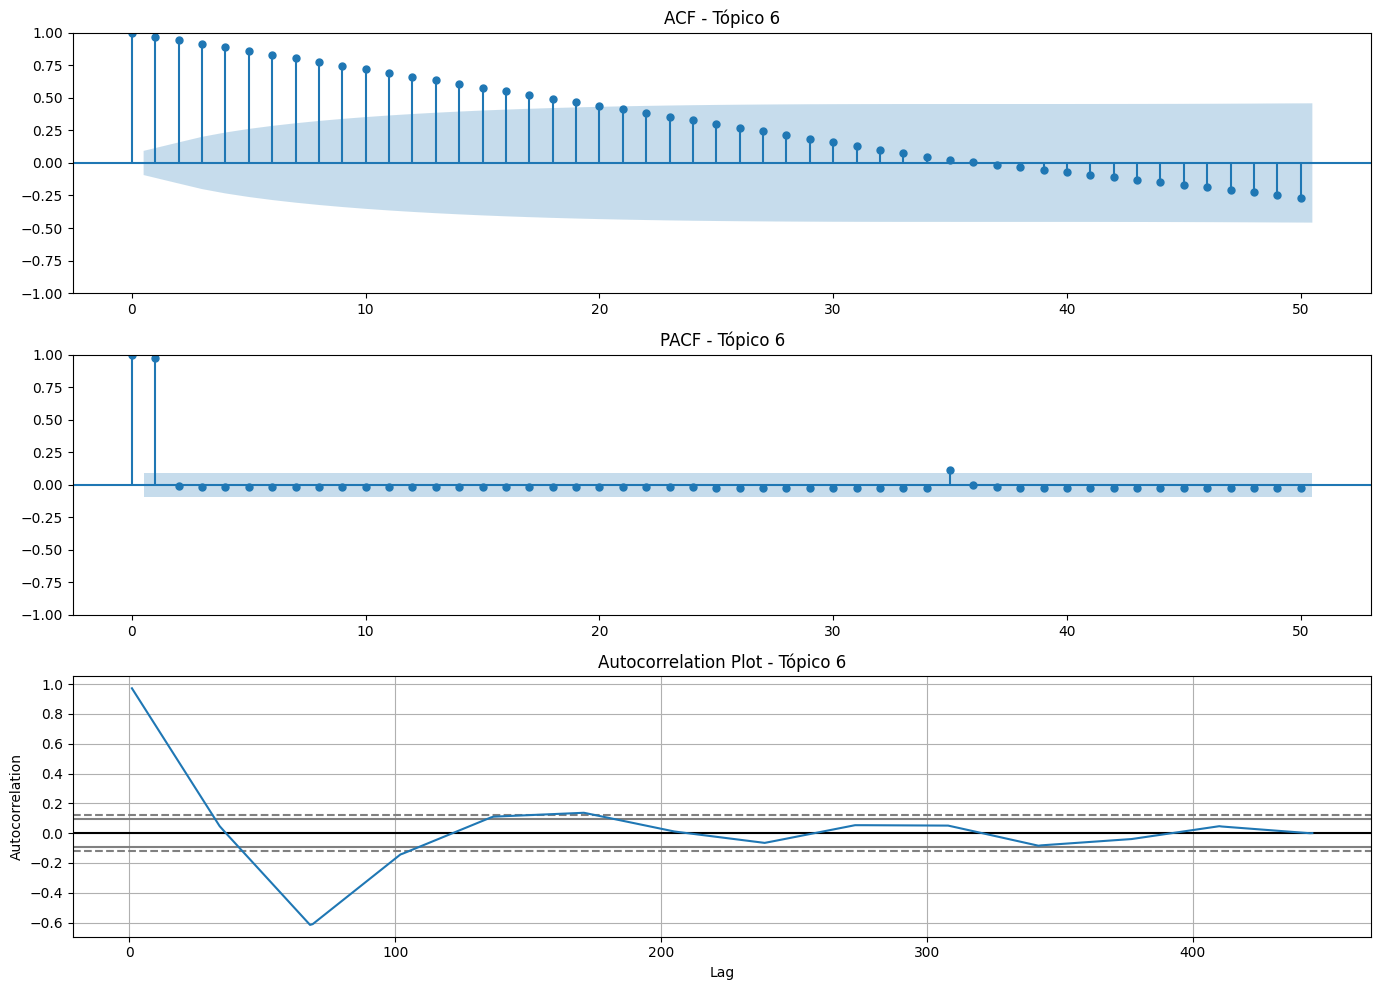


🔍 Análisis del Tópico 7


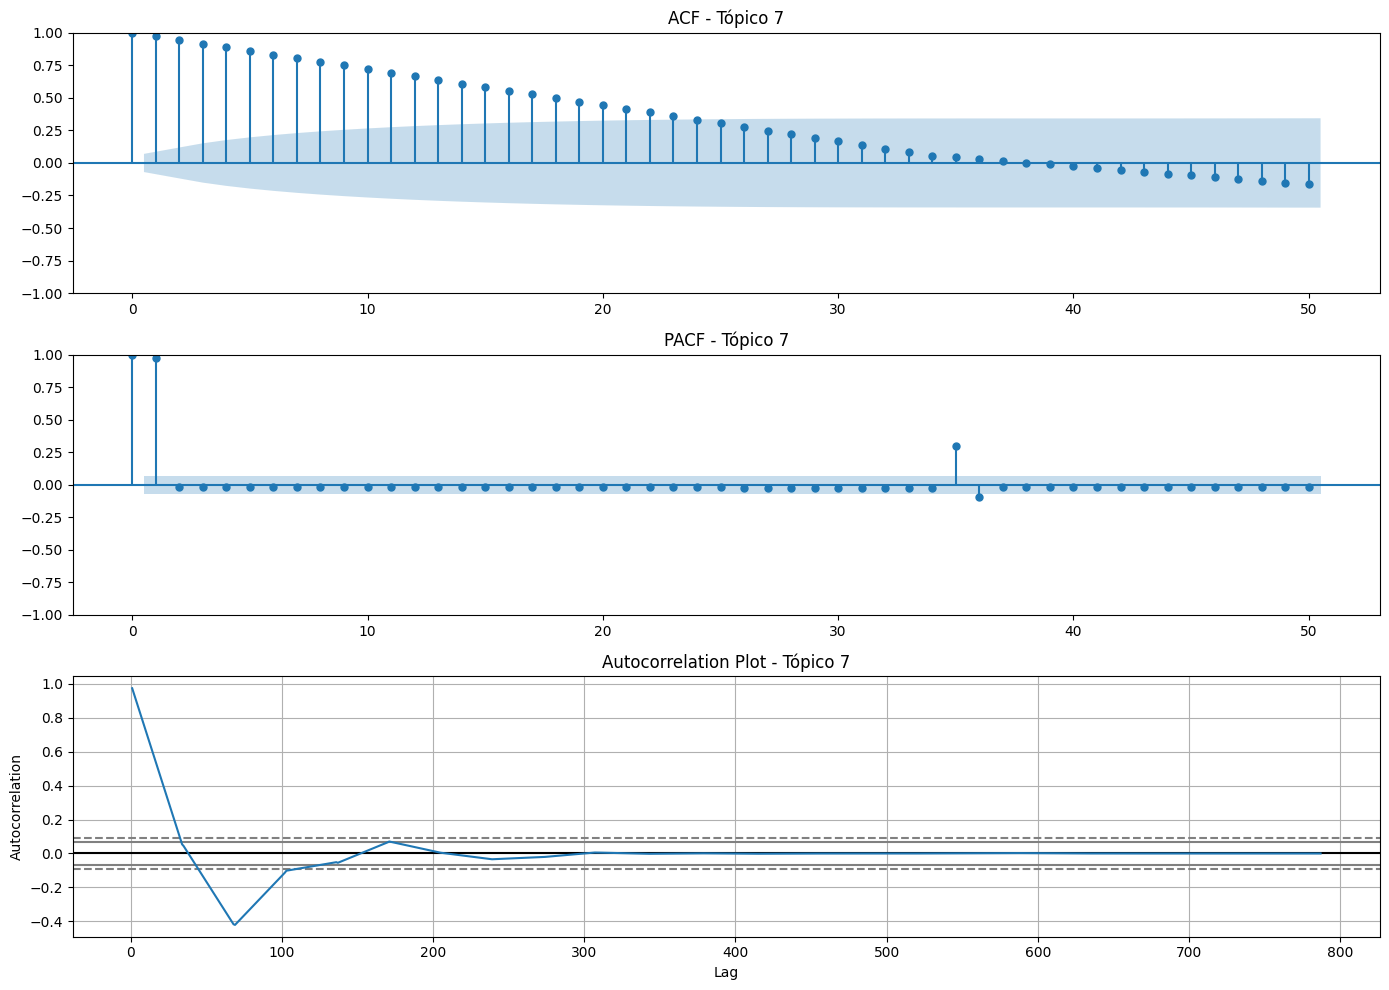


🔍 Análisis del Tópico 8


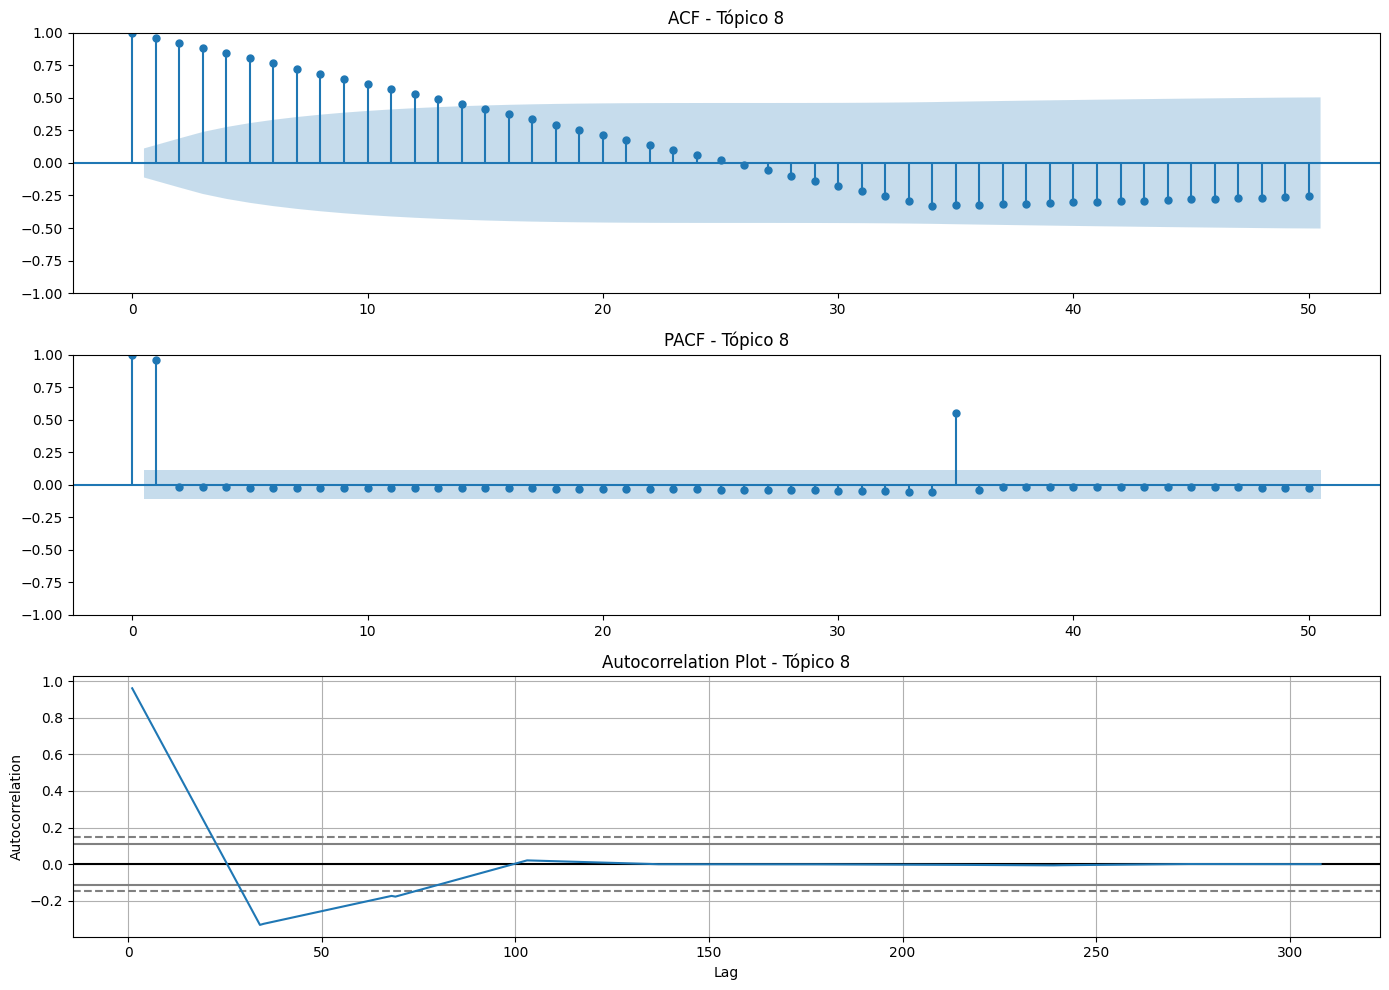


📋 Diagnóstico resumido:
   Tópico  ADF p-value  Estacionaria (ADF)  \
0       2       0.0022                True   
1       6       0.2241               False   
2       7       0.0143                True   
3       8       0.1258               False   

                                          Comentario  
0             Serie estacionaria tras diferenciación  
1  Serie aún no estacionaria → puede ser señal ca...  
2             Serie estacionaria tras diferenciación  
3  Serie aún no estacionaria → puede ser señal ca...  


In [40]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Índices de los tópicos a analizar
topics_to_analyze = [2, 6, 7, 8] 

# Almacenar resumen
diagnosticos = []

for idx in topics_to_analyze:
    print(f"\n🔍 Análisis del Tópico {idx}")
    df_resultado = df_ts_resultado[idx].copy()

    # Diferenciación de primer orden
    df_resultado['frequency_diff_1'] = np.append([0], np.diff(df_resultado['frequency']))

    # Test de Dickey-Fuller Aumentado (ADF)
    adf_result = adfuller(df_resultado['frequency_diff_1'].dropna())
    p_value = adf_result[1]
    estacionaria = p_value < 0.05

    # Graficar ACF, PACF y autocorrelation plot
    fig, ax = plt.subplots(nrows=3, figsize=(14, 10))

    plot_acf(df_resultado['frequency_diff_1'], lags=50, ax=ax[0])
    ax[0].set_title(f'ACF - Tópico {idx}')

    plot_pacf(df_resultado['frequency_diff_1'], lags=50, ax=ax[1])
    ax[1].set_title(f'PACF - Tópico {idx}')

    autocorrelation_plot(df_resultado['frequency_diff_1'], ax=ax[2])
    ax[2].set_title(f'Autocorrelation Plot - Tópico {idx}')

    plt.tight_layout()
    plt.show()

    # Diagnóstico textual
    resumen = {
        'Tópico': idx,
        'ADF p-value': round(p_value, 4),
        'Estacionaria (ADF)': estacionaria,
        'Comentario': (
            "Serie estacionaria tras diferenciación"
            if estacionaria else
            "Serie aún no estacionaria → puede ser señal cambiante"
        )
    }

    diagnosticos.append(resumen)


df_diagnostico = pd.DataFrame(diagnosticos)
print("\n Diagnóstico resumido:")
print(df_diagnostico)
